[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioRR-Tec/AprendizajeAutomatico/blob/master/Tema_4_AprendizajeAutomatico/notebook/Hyperparametros_Validacion.ipynb)

<h2><center>Hiperparámetros y validación de modelos</center></h2>

En temas anteriores, hemos platicado un poco acerca de la **receta básica** para aplicar un modelo de aprendizaje automático:

* Elija una clase de modelo
* Elija hiperparámetros de modelo
* Ajustar el modelo a los datos de entrenamiento
* Utilizar el modelo para analizar los datos

Las dos primeras partes de esto, la elección del modelo y los hiperparámetros, son quizás la parte más importante del uso eficaz de estas herramientas y técnicas. 

Para tomar una decisión informada, necesitamos una forma de validar que nuestro modelo y nuestros hiperparámetros se ajustan bien a los datos. Si bien esto puede parecer simple, existen algunas trampas que deben evitar para hacerlo de manera efectiva.

----

### Pensando en la validación del modelo

En principio, la validación del modelo es muy simple: después de elegir un modelo y sus hiperparámetros, podemos estimar qué tan efectivo es aplicándolo a algunos de los datos de entrenamiento y comparando la predicción con el valor conocido.

Las siguientes secciones muestran primero un enfoque ingenuo para la validación de modelos y por qué falla, antes de explorar el uso de la validación cruzada para una evaluación de modelos más sólida.

---

### Limpieza y disputa de datos.

El conjunto de datos del centro de servicios de [transfusión de sangre](https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center) es un conjunto de datos limpio. Este no será el caso de la mayoría de los otros conjuntos de datos. Entonces, este es el paso para inspeccionar y limpiar los datos, por ejemplo, manejar los valores faltantes ...


In [1]:
# Data cleansing and wrangling.
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data')

df = df.rename(columns={
    'Recency (months)': 'months_since_last_donation', 
    'Frequency (times)': 'number_of_donations', 
    'Monetary (c.c. blood)': 'total_volume_donated', 
    'Time (months)': 'months_since_first_donation', 
    'whether he/she donated blood in March 2007': 'made_donation_in_march_2007'
})

In [2]:
df

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0
...,...,...,...,...,...
743,23,2,500,38,0
744,21,2,500,52,0
745,23,3,750,62,0
746,39,1,250,39,0


In [3]:
# Split the data into training and test data sets.

# Seperating the independent and dependent features.
X = df.drop(columns=['made_donation_in_march_2007'])
y = df.made_donation_in_march_2007

# Split data into train and test using k-fold cross-validation
# with independent test data set.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=42
                                                   )

In [4]:
# Get quick initial metrics estimate.

# Using simple pandas value counts method
print(y_train.value_counts(normalize=True))

# Using sklearn accuracy_score
import numpy as np
from sklearn.metrics import accuracy_score

majority_class = y_train.mode()[0]
prediction = np.full(shape=y_train.shape, 
                     fill_value=majority_class)

accuracy_score(y_train, prediction)

0    0.768271
1    0.231729
Name: made_donation_in_march_2007, dtype: float64


0.768270944741533

### Ingeniería de funciones para optimizar las métricas.

---

La ingeniería de características es el proceso de utilizar el conocimiento del dominio de los datos para crear características que hacen que los algoritmos de aprendizaje automático funcionen. 

La ingeniería de funciones es fundamental para la aplicación del aprendizaje automático y es difícil y costosa.

---

Esto significa.... hay que identificar las relaciones entre características independientes y dependientes. Esto es con la ayuda de gráficos como diagramas de pares o matrices de correlación. Luego, las relaciones identificadas las podemos agregar como características polinomiales o de interacción.



In [5]:
# Data pre-processing, Feature selection and Model selection.

# Imports for pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression

# Create pipeline
pipeline = make_pipeline(\
                         RobustScaler(),
                         SelectKBest(f_classif),
                         LogisticRegression(solver='lbfgs'))

### Validación de Modelo

Los hiperparámetros son parámetros que no se aprenden dentro del modelo por sí mismo. Los hiperparámetros se pasan como argumentos al constructor.... 

Con base en la puntuación de validación cruzada, es posible obtener los mejores parámetros posibles.

Para el ajuste de hiperparámetros, **GridSearchCV** es una de las opciones. 

Ya que realiza una búsqueda exhaustiva sobre valores de parámetros específicos para el modelo. Aquí estamos pasando los hiperparámetros a los pasos en la canalización usando param_grid. CV se establece en 5 ya que vamos a realizar una validación cruzada de 5 veces. La puntuación se establece en precisión ya que queremos predecir la precisión del modelo.

In [6]:
# Model validation.
from sklearn.model_selection import GridSearchCV

param_grid = {
    'selectkbest__k': [1, 2, 3, 4],
    'logisticregression__class_weight': [None,'balanced'],
    'logisticregression__C': [.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]
}

gridsearch = GridSearchCV(pipeline, param_grid=param_grid, cv=5,
                         scoring='accuracy', verbose=1)

gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    3.3s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1,
                                                   1.0, 10.0, 100.0, 1000.0,
                                                   10000.0],
                         'logisticregression__class_weight': [None, 'balanced'],
                         'selectkbest__k': [1, 2, 3, 4]},
             scoring='accuracy', verbose=1)

### Interpreta los resultados.

GridSearchCV devuelve poca información importante como:

* best_estimator_, estimador que dio la puntuación más alta. Usando esto podemos obtener la información sobre las características seleccionadas.
* best_score_, Puntuación media validada de forma cruzada del best_estimator. Para nuestro conjunto de problemas, obtuvimos una mejor puntuación del 78% para nuestra primera iteración. Esto no parece mucho, pero ya hemos superado nuestra puntuación de precisión de referencia.
* best_params_, configuración de parámetro que dio los mejores resultados en los datos de reserva. Para los hiperparámetros que pasaron al modelo, la configuración siguiente dio los mejores resultados.


    * "Regresión logística__C": 1.0

    * ‘Logisticregression__class_weight’: Ninguno

    * "Selectkbest__k": 4

In [7]:
# Interpret the results.

# Best cross validation score
print('Cross Validation Score:', gridsearch.best_score_)

# Best parameters which resulted in the best score
print('Best Parameters:', gridsearch.best_params_)

# Which features were selected?
selector = gridsearch.best_estimator_.named_steps['selectkbest']
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print()
print('Features not selected:')
for name in unselected_names:
    print(name)

Cross Validation Score: 0.7807522123893806
Best Parameters: {'logisticregression__C': 1.0, 'logisticregression__class_weight': None, 'selectkbest__k': 4}
Features selected:
months_since_last_donation
number_of_donations
total_volume_donated
months_since_first_donation

Features not selected:


---
---
Esto finaliza la primera iteración de la validación del modelo. Ahora podemos volver atrás y repetir el proceso a partir del paso de ingeniería de funciones.

Al final de cada iteración, podemos verificar el cambio en la puntuación de precisión. Repite el procedimiento hasta alcanzar la puntuación de precisión deseada o las métricas elegidas.

### Obten el mejor modelo y compáralo con el conjunto de datos de prueba.

Después de elegir el modelo final, verifica su rendimiento utilizando el conjunto de datos de prueba. Aquí obtenemos una puntuación de precisión del 75% en el conjunto de datos de prueba.

In [8]:
#Get the best model and check it against test data set.

# Predict with X_test features
y_pred = gridsearch.predict(X_test)

# Compare predictions to y_test labels
test_score = accuracy_score(y_test, y_pred)
print('Accuracy Score on test data set:', test_score)

Accuracy Score on test data set: 0.7540106951871658


---

### Ejemplo de Validación cruzada con regresión lineal

* Experimentos para comprender el sobreajuste
* Construyendo un modelo de regresión lineal sin validación cruzada
* Problemas en el enfoque actual
* Validación cruzada: un resumen rápido
* Validación cruzada en sklearn:
    * CV de doblez
    * Ajuste de hiperparámetros usando CV
    * Otros esquemas de CV

### Experimentos para comprender el sobreajuste

En esta sección, repasemos rápidamente algunos experimentos para comprender cómo se ve el sobreajuste. Realizaremos algunos experimentos usando regresión polinomial.

In [9]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings # supress warnings

In [44]:
# import Housing.csv
housing = pd.read_csv("../data/Housing.csv")
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [45]:
housing.shape

(545, 13)

Para el primer experimento, haremos una regresión con una sola característica. Filtremos los datos para que solo contengan área y precio.

In [46]:
# filter only area and price
df = housing.loc[:, ['area', 'price']]
df.head()

,area,price
0,7420,13300000
1,8960,12250000
2,9960,12250000
3,7500,12215000
4,7420,11410000


<AxesSubplot:xlabel='area', ylabel='price'>

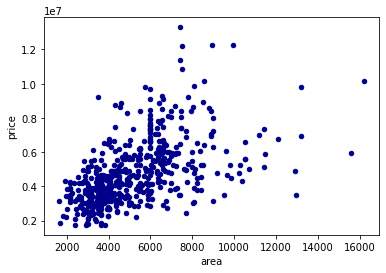

In [48]:
df.plot.scatter(x='area',

                      y='price',

                      c='DarkBlue')

In [49]:
# recaling the variables (both)
df_columns = df.columns
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

# rename columns (since now its an np array)
df = pd.DataFrame(df)
df.columns = df_columns

df.head()

,area,price
0,0.396564,1.000000
1,0.502405,0.909091
2,0.571134,0.909091
3,0.402062,0.906061
4,0.396564,0.836364


<AxesSubplot:xlabel='area', ylabel='price'>

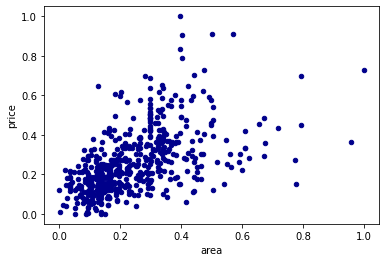

In [50]:
df.plot.scatter(x='area',
                      y='price',
                      c='DarkBlue')

<AxesSubplot:xlabel='area', ylabel='price'>

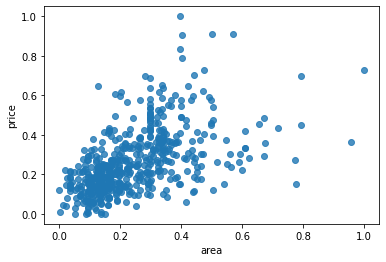

In [52]:
# visualise area-price relationship
sns.regplot(x="area", y="price", data=df, fit_reg=False)

In [53]:
# split into train and test
df_train, df_test = train_test_split(df, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 10)
print(len(df_train))
print(len(df_test))

381
164


In [55]:
# split into X and y for both train and test sets
# reshaping is required since sklearn requires the data to be in shape
# (n, 1), not as a series of shape (n, )
X_train = df_train['area']
X_train = X_train.values.reshape(-1, 1)
y_train = df_train['price']

X_test = df_test['area']
X_test = X_test.values.reshape(-1, 1)
y_test = df_test['price']

In [56]:
# fit multiple polynomial features
degrees = [1, 2, 3, 6, 10, 20]

# initialise y_train_pred and y_test_pred matrices to store the train and test predictions
# each row is a data point, each column a prediction using a polynomial of some degree
y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)

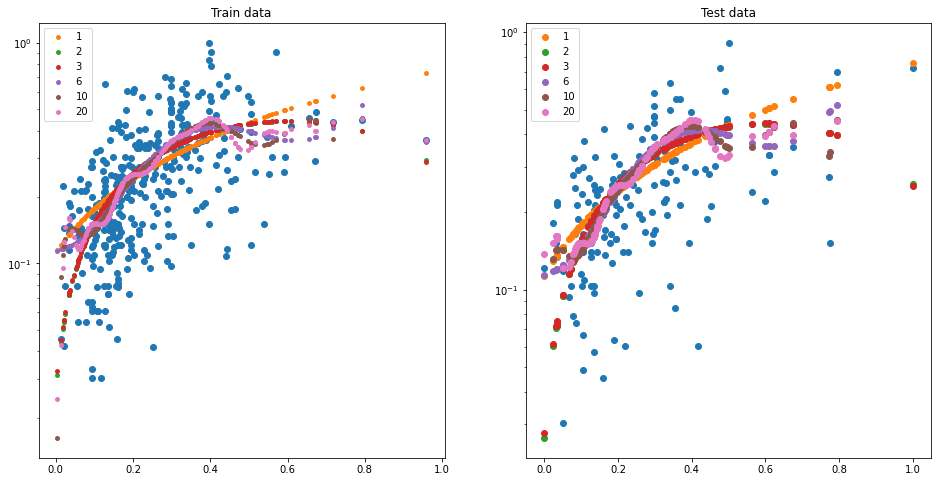

In [57]:
# visualise train and test predictions
# note that the y axis is on a log scale

plt.figure(figsize=(16, 8))

# train data
plt.subplot(121)
plt.scatter(X_train, y_train)
plt.yscale('log')
plt.title("Train data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_train, y_train_pred[:, i], s=15, label=str(degree))
    plt.legend(loc='upper left')
    
# test data
plt.subplot(122)
plt.scatter(X_test, y_test)
plt.yscale('log')
plt.title("Test data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')

In [58]:
# compare r2 for train and test sets (for all polynomial fits)
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, i]), 2)
    test_r2 = round(sklearn.metrics.r2_score(y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: train score={1}, test score={2}".format(degree, 
                                                                         train_r2, 
                                                                         test_r2))

R-squared values: 

Polynomial degree 1: train score=0.29, test score=0.25
Polynomial degree 2: train score=0.34, test score=0.22
Polynomial degree 3: train score=0.34, test score=0.22
Polynomial degree 6: train score=0.36, test score=0.11
Polynomial degree 10: train score=0.37, test score=-108.76
Polynomial degree 20: train score=0.38, test score=-307071892464.36


### Creación de un modelo sin validación cruzada

Construyamos ahora un modelo de regresión múltiple. Primero, construyamos un modelo de MLR básico sin ninguna validación cruzada, etc.



In [59]:
# data preparation

# list of all the "yes-no" binary categorical variables
# we'll map yes to 1 and no to 0
binary_vars_list =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# defining the map function
def binary_map(x):
    return x.map({'yes': 1, "no": 0})

# applying the function to the housing variables list
housing[binary_vars_list] = housing[binary_vars_list].apply(binary_map)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [60]:
# 'dummy' variables
# get dummy variables for 'furnishingstatus' 
# also, drop the first column of the resulting df (since n-1 dummy vars suffice)
status = pd.get_dummies(housing['furnishingstatus'], drop_first = True)
status.head()

,semi-furnished,unfurnished
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0


In [61]:
# concat the dummy variable df with the main df
housing = pd.concat([housing, status], axis = 1)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0


In [62]:


# 'furnishingstatus' since we alreday have the dummy vars
housing.drop(['furnishingstatus'], axis = 1, inplace = True)
housing.head()



,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


In [63]:
# train-test 70-30 split
df_train, df_test = train_test_split(housing, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 100)

# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns 
numeric_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.169697,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,0,1
19,0.615152,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,1,0
159,0.321212,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,0,0
35,0.548133,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,0,0
28,0.575758,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,0,1


In [64]:
# apply rescaling to the test set also
df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])
df_test.head()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
265,0.247651,0.084536,0.333333,0.000000,0.333333,1,0,0,0,0,0.000000,1,1,0
54,0.530201,0.298969,0.333333,0.333333,0.333333,1,1,0,0,1,0.333333,0,1,0
171,0.328859,0.592371,0.333333,0.000000,0.000000,1,0,0,0,0,0.333333,1,1,0
244,0.261745,0.252234,0.333333,0.000000,0.333333,1,1,1,0,0,0.000000,1,1,0
268,0.245638,0.226804,0.666667,0.000000,0.333333,1,0,0,0,1,0.000000,0,1,0


In [65]:
# divide into X_train, y_train, X_test, y_test
y_train = df_train.pop('price')
X_train = df_train

y_test = df_test.pop('price')
X_test = df_test

In [66]:
# first model with an arbitrary choice of n_features
# running RFE with number of features=10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=10)             
rfe = rfe.fit(X_train, y_train)

In [67]:
# tuples of (feature name, whether selected, ranking)
# note that the 'rank' is > 1 for non-selected features
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('area', True, 1),
 ('bedrooms', True, 1),
 ('bathrooms', True, 1),
 ('stories', True, 1),
 ('mainroad', True, 1),
 ('guestroom', True, 1),
 ('basement', False, 3),
 ('hotwaterheating', True, 1),
 ('airconditioning', True, 1),
 ('parking', True, 1),
 ('prefarea', True, 1),
 ('semi-furnished', False, 4),
 ('unfurnished', False, 2)]

In [69]:
# predict prices of X_test
y_pred = rfe.predict(X_test)

# evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.5812051458999572


In [70]:
# try with another value of RFE
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=6)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.535044502757882


### Ahora Cross-Validation

In [71]:
# k-fold CV (using all the 13 variables)
lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
scores      

array([0.6829775 , 0.69324306, 0.6762109 , 0.61782891, 0.59266171])

In [72]:
# the other way of doing the same thing (more explicit)

# create a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
scores   

array([0.59930574, 0.71307628, 0.61325733, 0.62739077, 0.6212937 ])

In [73]:
# can tune other metrics, such as MSE
scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores

array([-0.00806336, -0.00658776, -0.0064797 , -0.0070743 , -0.01523682])

### Ajuste de hiperparámetros usando CV-GridSearch¶

Un uso común de la validación cruzada es para ajustar los hiperparámetros de un modelo. La técnica más común es lo que se llama validación cruzada de búsqueda de cuadrícula.

In [74]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 14))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)          

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.8s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]}],
             return_train_score=True, scoring='r2', verbose=1)

In [75]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.013962,1.669152e-03,0.002394,0.000489,1,{'n_features_to_select': 1},0.172606,0.351721,0.206887,0.165910,...,0.243658,0.077627,13,0.302971,0.265961,0.280611,0.300768,0.269025,0.283867,0.015506
1,0.010973,2.089536e-03,0.001992,0.000631,2,{'n_features_to_select': 2},0.335665,0.428751,0.439969,0.505321,...,0.438360,0.058374,12,0.505799,0.489802,0.462091,0.474178,0.471907,0.480755,0.015355
2,0.011171,2.129969e-03,0.002194,0.000399,3,{'n_features_to_select': 3},0.421848,0.539257,0.491515,0.604426,...,0.516805,0.059902,11,0.568074,0.544917,0.542889,0.534685,0.542412,0.546596,0.011289
3,0.010771,1.163105e-03,0.002194,0.000746,4,{'n_features_to_select': 4},0.449487,0.567101,0.494461,0.600237,...,0.526272,0.053074,10,0.587523,0.564018,0.549490,0.541496,0.549291,0.558364,0.016296
4,0.009973,8.919104e-04,0.001995,0.000631,5,{'n_features_to_select': 5},0.494779,0.610200,0.492807,0.590812,...,0.541889,0.049257,8,0.620038,0.597033,0.584663,0.549413,0.589397,0.588109,0.022847
5,0.008776,7.463402e-04,0.002593,0.000488,6,{'n_features_to_select': 6},0.512477,0.628849,0.488411,0.527379,...,0.541063,0.048029,9,0.626959,0.603122,0.596348,0.606852,0.601063,0.606869,0.010602
6,0.007181,1.163105e-03,0.001995,0.000631,7,{'n_features_to_select': 7},0.568887,0.664093,0.552385,0.534634,...,0.577636,0.045006,7,0.658577,0.638501,0.630137,0.646285,0.638313,0.642363,0.009582
7,0.007580,1.017149e-03,0.002393,0.000489,8,{'n_features_to_select': 8},0.570639,0.665608,0.592323,0.550001,...,0.591795,0.039428,6,0.674146,0.640825,0.654028,0.658665,0.657277,0.656988,0.010651
8,0.006981,8.917503e-04,0.002593,0.000488,9,{'n_features_to_select': 9},0.578843,0.694189,0.606220,0.590777,...,0.615352,0.040767,4,0.676043,0.652605,0.659579,0.668996,0.664321,0.664309,0.007988
9,0.005985,1.097762e-06,0.002194,0.000399,10,{'n_features_to_select': 10},0.574376,0.693197,0.601972,0.594335,...,0.608547,0.043498,5,0.686032,0.661729,0.674558,0.678443,0.677153,0.675583,0.007910


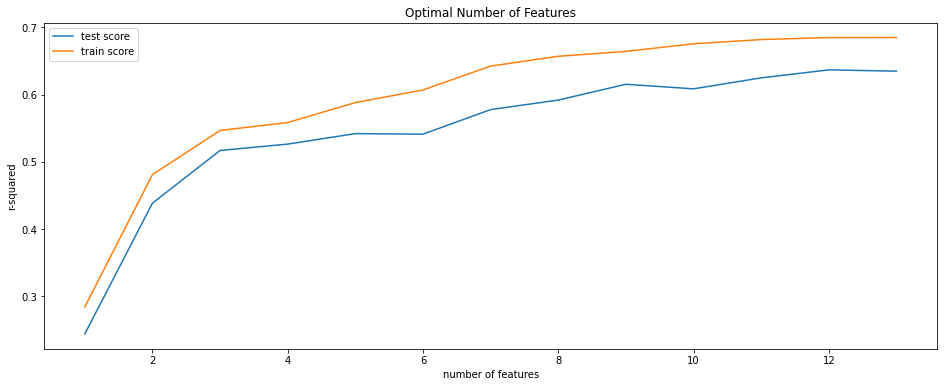

In [76]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [77]:
# final model
n_features_optimal = 10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = lm.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.5995575338728532


Observa que la puntuación de la prueba está muy cerca de la 'puntuación media de la prueba' en los k-pliegues (alrededor del 60%). En general, la puntuación media estimada por CV suele ser una buena estimación de la puntuación de la prueba.

### Otro ejemplo: predicción del precio del automóvil

In [79]:
# reading the dataset
cars = pd.read_csv("https://gist.githubusercontent.com/abhi18av/cdf70d2b2d9a709fc2900698c06e7664/raw/f6f2647672a516c776b2fc232417c2a41aa2453a/CarPrice_Assignment.csv")

In [80]:
# All data preparation steps in this cell

# converting symboling to categorical
cars['symboling'] = cars['symboling'].astype('object')


# create new column: car_company
p = re.compile(r'\w+-?\w+')
cars['car_company'] = cars['CarName'].apply(lambda x: re.findall(p, x)[0])


# replacing misspelled car_company names
# volkswagen
cars.loc[(cars['car_company'] == "vw") | 
         (cars['car_company'] == "vokswagen")
         , 'car_company'] = 'volkswagen'
# porsche
cars.loc[cars['car_company'] == "porcshce", 'car_company'] = 'porsche'
# toyota
cars.loc[cars['car_company'] == "toyouta", 'car_company'] = 'toyota'
# nissan
cars.loc[cars['car_company'] == "Nissan", 'car_company'] = 'nissan'
# mazda
cars.loc[cars['car_company'] == "maxda", 'car_company'] = 'mazda'


# drop carname variable
cars = cars.drop('CarName', axis=1)


# split into X and y
X = cars.loc[:, ['symboling', 'fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carlength',
       'carwidth', 'carheight', 'curbweight', 'enginetype', 'cylindernumber',
       'enginesize', 'fuelsystem', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'car_company']]
y = cars['price']


# creating dummy variables for categorical variables
cars_categorical = X.select_dtypes(include=['object'])
cars_categorical.head()


# convert into dummies
cars_dummies = pd.get_dummies(cars_categorical, drop_first=True)
cars_dummies.head()


# drop categorical variables 
X = X.drop(list(cars_categorical.columns), axis=1)


# concat dummy variables with X
X = pd.concat([X, cars_dummies], axis=1)


# rescale the features
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols


# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=40)

In [81]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 40))}]

# specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)      

Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:   15.8s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27, 28, 29, 30, 31, ...]}],
             return_train_score=True, scoring='r2', verbose=1)

In [82]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.091156,0.005069,0.002993,8.915913e-04,2,{'n_features_to_select': 2},0.712322,0.673284,0.839691,0.643727,...,0.716972,0.066867,35,0.693638,0.809346,0.768171,0.798515,0.798908,0.773715,0.042337
1,0.090670,0.008271,0.003191,9.784607e-04,3,{'n_features_to_select': 3},0.817568,0.720574,0.864579,0.675851,...,0.704190,0.147102,38,0.796890,0.868796,0.833999,0.850420,0.845840,0.839189,0.023930
2,0.103827,0.011883,0.003592,4.895991e-04,4,{'n_features_to_select': 4},0.829413,0.812420,0.862303,0.735701,...,0.736991,0.151742,33,0.834392,0.904158,0.894407,0.881821,0.850000,0.872956,0.026557
3,0.104126,0.009382,0.003985,8.880623e-04,5,{'n_features_to_select': 5},0.669211,0.814914,0.864962,0.768708,...,0.710741,0.151825,37,0.863963,0.907896,0.897645,0.911010,0.895627,0.895228,0.016692
4,0.102088,0.006505,0.003391,1.016541e-03,6,{'n_features_to_select': 6},0.675174,0.829293,0.873897,0.764830,...,0.716971,0.153020,36,0.864405,0.910425,0.901539,0.912918,0.909751,0.899808,0.018110
5,0.099336,0.013944,0.003192,3.986846e-04,7,{'n_features_to_select': 7},0.619241,0.825256,0.854447,0.765352,...,0.722678,0.118774,34,0.875107,0.913424,0.909011,0.914559,0.926074,0.907635,0.017213
6,0.117187,0.006493,0.003989,6.302991e-04,8,{'n_features_to_select': 8},0.608348,0.827366,0.848157,0.763983,...,0.768783,0.085134,31,0.887177,0.918335,0.924470,0.914797,0.930265,0.915009,0.014886
7,0.092958,0.005908,0.003190,1.162491e-03,9,{'n_features_to_select': 9},0.638207,0.835079,0.848157,0.763969,...,0.773889,0.074660,29,0.889975,0.921886,0.924470,0.914826,0.934186,0.917069,0.014900
8,0.111900,0.041976,0.003190,1.162845e-03,10,{'n_features_to_select': 10},0.637811,0.819335,0.854378,0.763966,...,0.776128,0.074982,27,0.889975,0.925014,0.931169,0.914828,0.939454,0.920088,0.017068
9,0.181159,0.103742,0.004388,1.353626e-03,11,{'n_features_to_select': 11},0.637811,0.859000,0.860012,0.684470,...,0.770847,0.092361,30,0.889975,0.933753,0.936501,0.924168,0.940519,0.924983,0.018315


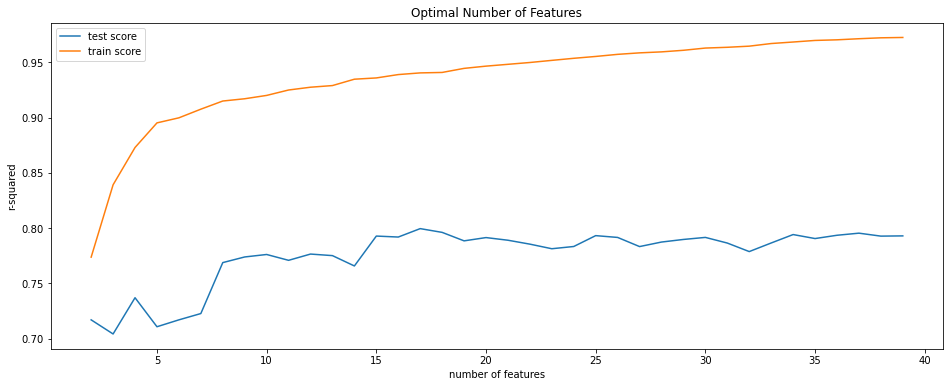

In [83]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')